# **Modeling experiments + evaluation**


Using 50 features for model training

KNN results:
MAE: 31.4456, RMSE: 41.2330, R2: 0.0155, train_time(s): 0.00

SVR results:
MAE: 29.4079, RMSE: 34.1101, R2: 0.3262, train_time(s): 36.28

RandomForest results:
MAE: 15.5064, RMSE: 19.9243, R2: 0.7701, train_time(s): 8.54

Model comparison:
          model        MAE       RMSE        R2  train_time_s
2  RandomForest  15.506450  19.924292  0.770117      8.537190
1           SVR  29.407874  34.110128  0.326237     36.283278
0           KNN  31.445556  41.232953  0.015469      0.004290

Best model by RMSE: RandomForest


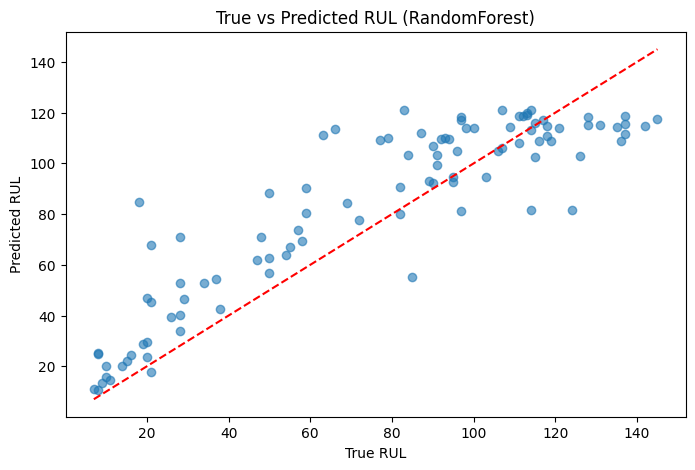

In [12]:
def prepare_train_test_matrices(df_train_fe, df_test_fe, feature_list):
    X_train = df_train_fe[feature_list].values
    y_train = df_train_fe['RUL'].values
    X_test = df_test_fe[feature_list].values
    y_test = df_test_RUL['RUL'].values
    return X_train, X_test, y_train, y_test

# reduce features for models to keep compute reasonable in examples
feature_names = Selected_Features[:50] if len(Selected_Features) > 50 else Selected_Features
print('\nUsing', len(feature_names), 'features for model training')

X_train_raw, X_test_raw, y_train, y_test = prepare_train_test_matrices(df_train_fe, df_test_max_fe, feature_names)

# scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

results = []

def evaluate_and_record(model, X_train, y_train, X_test, y_test, label='model'):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    print(f"\n{label} results:")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, train_time(s): {train_time:.2f}")

    results.append({'model': label, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'train_time_s': train_time})
    return preds

# KNN
knn = KNeighborsRegressor(n_neighbors=9)
knn_preds = evaluate_and_record(knn, X_train, y_train, X_test, y_test, label='KNN')

# SVR (slow on large feature sets) - keep kernel parameters conservative
svr = SVR(kernel='rbf', C=100, gamma=0.5, epsilon=0.01)
svr_preds = evaluate_and_record(svr, X_train, y_train, X_test, y_test, label='SVR')

# Random Forest
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features='sqrt', random_state=34)
rf_preds = evaluate_and_record(rf, X_train, y_train, X_test, y_test, label='RandomForest')

# Show comparison table
res_df = pd.DataFrame(results).sort_values('RMSE')
print('\nModel comparison:')
print(res_df)

# plot true vs predicted for best model (lowest RMSE)
best = res_df.iloc[0]['model']
print(f"\nBest model by RMSE: {best}")

best_preds = {'KNN': knn_preds, 'SVR': svr_preds, 'RandomForest': rf_preds}[best]
plt.figure(figsize=(8,5))
plt.scatter(y_test, best_preds, alpha=0.6)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title(f'True vs Predicted RUL ({best})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# **LSTM model (sequence model)**


Preparing data for a simple LSTM demonstration...


2025-09-24 20:53:14.840919: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 6319.5308 - mae: 67.7886 - val_loss: 604.8667 - val_mae: 19.8105
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 443.1028 - mae: 16.3814 - val_loss: 698.7335 - val_mae: 20.0663
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 361.5289 - mae: 14.0442 - val_loss: 548.0601 - val_mae: 18.0498
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 343.0988 - mae: 13.7121 - val_loss: 358.5339 - val_mae: 13.6370
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 344.0293 - mae: 13.6194 - val_loss: 1152.8588 - val_mae: 26.1495
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 336.6162 - mae: 13.5726 - val_loss: 438.2192 - val_mae: 15.4217
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 329.9514 - mae: 13.4527 - val_loss: 729.1827 - val_mae: 20.3341
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 326.2903 - mae: 13.2372 - val_loss: 1068.7800 - val_mae: 25.6177
Epoc

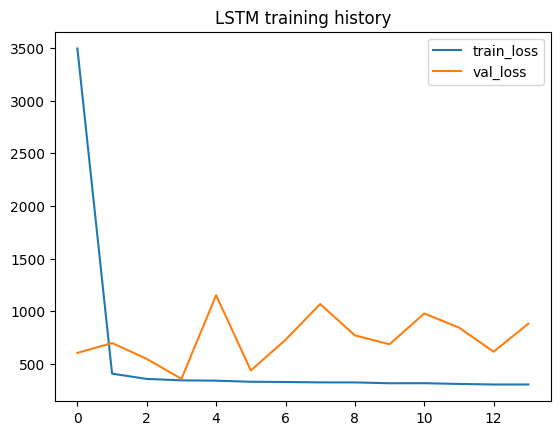

In [13]:
# For LSTM we reshape using features from the last timestep per engine (or build sequences).
# Here we demonstrate a simple approach by treating each engine's time-series as multiple samples
# with a single timestep (not ideal). For a proper sequence model you'd create sliding windows
# of length T and predict RUL at window end.

try:
    print('\nPreparing data for a simple LSTM demonstration...')
    # We'll use X_train and X_test prepared earlier but reshape to (n_samples, timesteps=1, n_features)
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(64, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    hist = model.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test),
                     epochs=50, batch_size=64, callbacks=[es], verbose=1)

    y_pred_lstm = model.predict(X_test_lstm).ravel()
    print('\nLSTM evaluation:')
    print('MAE:', mean_absolute_error(y_test, y_pred_lstm))
    print('RMSE:', mean_squared_error(y_test, y_pred_lstm, squared=False))
    print('R2:', r2_score(y_test, y_pred_lstm))

    plt.figure()
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('LSTM training history')
    plt.show()
except Exception as e:
    print('Skipping LSTM demo due to error (likely compute or memory):', e)

**Metrics & "accuracy"-like reports for RUL (regression)**

--- KNN ---
MAE: 31.4456 | RMSE: 41.2330 | R2: 0.0155 (1.5%)
MAPE: 80.00%
% within ±5: 10.00 | ±10: 23.00 | ±20: 48.00

--- SVR ---
MAE: 29.4079 | RMSE: 34.1101 | R2: 0.3262 (32.6%)
MAPE: 96.09%
% within ±5: 4.00 | ±10: 16.00 | ±20: 34.00

--- RandomForest ---
MAE: 15.5064 | RMSE: 19.9243 | R2: 0.7701 (77.0%)
MAPE: 37.25%
% within ±5: 19.00 | ±10: 44.00 | ±20: 72.00

--- LSTM ---
MAE: 13.6370 | RMSE: 18.9350 | R2: 0.7924 (79.2%)
MAPE: 24.25%
% within ±5: 32.00 | ±10: 51.00 | ±20: 77.00



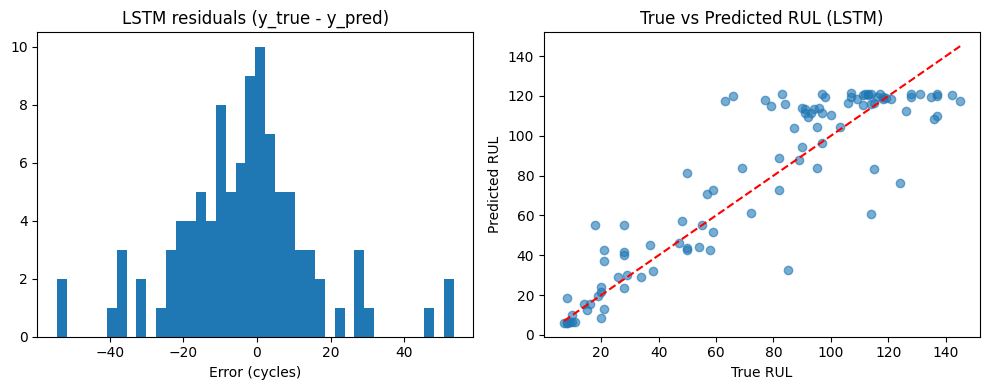

Classification (horizon=30) for KNN:
              precision    recall  f1-score   support

           0      0.815     1.000     0.898        75
           1      1.000     0.320     0.485        25

    accuracy                          0.830       100
   macro avg      0.908     0.660     0.692       100
weighted avg      0.861     0.830     0.795       100

Confusion matrix:
 [[75  0]
 [17  8]]

Classification (horizon=30) for SVR:
              precision    recall  f1-score   support

           0      0.750     1.000     0.857        75
           1      0.000     0.000     0.000        25

    accuracy                          0.750       100
   macro avg      0.375     0.500     0.429       100
weighted avg      0.562     0.750     0.643       100

Confusion matrix:
 [[75  0]
 [25  0]]

Classification (horizon=30) for RandomForest:
              precision    recall  f1-score   support

           0      0.882     1.000     0.938        75
           1      1.000     0.600     0

In [14]:
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # for optional binary framing
# import matplotlib.pyplot as plt

def compute_regression_metrics(y_true, y_pred, clip_small_true=True):
    """Return basic regression metrics and pragmatic accuracy measures."""
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    # MAPE: avoid division by zero by clipping true values at 1
    denom = np.clip(np.abs(y_true), 1e-6, None) if not clip_small_true else np.clip(np.abs(y_true), 1, None)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

    # Pragmatic "accuracy" within ±N cycles
    within_5  = np.mean(np.abs(y_true - y_pred) <= 5)  * 100.0
    within_10 = np.mean(np.abs(y_true - y_pred) <= 10) * 100.0
    within_20 = np.mean(np.abs(y_true - y_pred) <= 20) * 100.0

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'R2(%)': r2 * 100.0,
        'MAPE(%)': mape,
        'within_5_cycles_%': within_5,
        'within_10_cycles_%': within_10,
        'within_20_cycles_%': within_20
    }

def print_metrics_table(name, metrics):
    print(f"--- {name} ---")
    print(f"MAE: {metrics['MAE']:.4f} | RMSE: {metrics['RMSE']:.4f} | R2: {metrics['R2']:.4f} ({metrics['R2(%)']:.1f}%)")
    print(f"MAPE: {metrics['MAPE(%)']:.2f}%")
    print(f"% within ±5: {metrics['within_5_cycles_%']:.2f} | ±10: {metrics['within_10_cycles_%']:.2f} | ±20: {metrics['within_20_cycles_%']:.2f}")
    print()

# Collect model predictions you've computed (update names if different)
predictions = {
    'KNN': knn_preds,
    'SVR': svr_preds,
    'RandomForest': rf_preds,
}
# If you ran LSTM and have y_pred_lstm:
try:
    predictions['LSTM'] = y_pred_lstm
except NameError:
    pass

# Evaluate & show metrics
summary = {}
for name, preds in predictions.items():
    metrics = compute_regression_metrics(y_test, preds)
    print_metrics_table(name, metrics)
    summary[name] = metrics

# Plot residual distribution and true vs predicted for the best model by RMSE
# find best model by RMSE
best_model = min(summary.keys(), key=lambda k: summary[k]['RMSE'])
best_preds = predictions[best_model]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist((y_test - best_preds), bins=40)
plt.title(f'{best_model} residuals (y_true - y_pred)')
plt.xlabel('Error (cycles)')

plt.subplot(1,2,2)
plt.scatter(y_test, best_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title(f'True vs Predicted RUL ({best_model})')
plt.tight_layout()
plt.show()

# -------------------------
# Optional: turn RUL into binary "failure soon" label and compute classification accuracy
# (useful if stakeholder prefers a classification risk score)
# Example: failure if RUL <= horizon (e.g., 30 cycles)
# -------------------------
from sklearn.metrics import classification_report, confusion_matrix

horizon = 30
y_true_bin = (y_test <= horizon).astype(int)

for name, preds in predictions.items():
    preds_bin = (np.asarray(preds).ravel() <= horizon).astype(int)
    print(f"Classification (horizon={horizon}) for {name}:")
    print(classification_report(y_true_bin, preds_bin, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_true_bin, preds_bin))
    print()